# WGAN-GP Training

## imports

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt

from models.WGANGP import WGANGP
from utils.loaders import load_celeb

import pickle


/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

## data

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

In [4]:
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

Found 202599 images belonging to 1 classes.


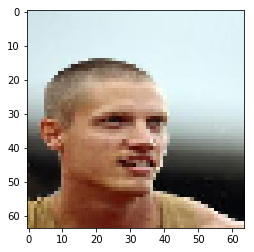

In [5]:
plt.imshow((x_train[0][0][0]+1)/2)

## architecture

In [6]:
if mode == 'build':

    gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
            , critic_conv_filters = [64,128,256,512]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,2]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.0002
            , generator_initial_dense_layer_size = (4, 4, 512)
            , generator_upsample = [1,1,1,1]
            , generator_conv_filters = [256,128,64,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [2,2,2,2]
            , generator_batch_norm_momentum = 0.9
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.0002
            , optimiser = 'adam'
            , grad_weight = 10
            , z_dim = 100
            , batch_size = BATCH_SIZE
            )

    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))




(64, 64, 64, 3)


In [7]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 64, 64, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0         
__________

In [8]:
gan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
__________

## training

In [10]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
BATCH_SIZE = 64

In [11]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 (5, 1) [D loss: (-0.6)(R -5.1, F -0.9, G 0.5)] [G loss: 1.8]
1 (5, 1) [D loss: (-56.7)(R -92.7, F 0.2, G 3.6)] [G loss: -2.1]
2 (5, 1) [D loss: (-95.4)(R -156.0, F 16.5, G 4.4)] [G loss: -15.5]


KeyboardInterrupt: 

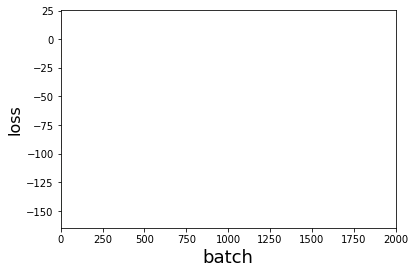

In [12]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()
